<a href="https://colab.research.google.com/github/HimanshiTomer/Energy-Load-Forecasting/blob/main/MinorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/EnergyLoadForecasting/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Essential Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import itertools, warnings, math, time
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12,5)
sns.set(style='whitegrid')

helper functions

In [3]:
def make_period_index_month(df, month_col='month'):
    """Convert YYYY-MM month column to PeriodIndex(M) and drop original column."""
    df = df.copy()
    df[month_col] = pd.to_datetime(df[month_col], format='%Y-%m', errors='coerce')
    df = df[df[month_col].notna()]  # FILTER OUT COPYRIGHT ROWS LEGALLY
    df.index = df[month_col].dt.to_period('M')
    df = df.drop(columns=[month_col])
    return df

def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return {'MSE':mse, 'RMSE':rmse, 'MAE':mae}

# Loading the Dataset

In [7]:
req_raw = pd.read_csv(base_path + 'electricity_requirement_mu_2021_2025.csv')
temp_raw = pd.read_csv(base_path + 'temperature_india_monthly_2021_2025.csv')
iip_raw = pd.read_csv(base_path + 'iip_yoy_2021_2025.csv')
fest_raw = pd.read_csv(base_path + 'festival_index_2021_2025.csv')

req_raw.tail(), temp_raw.tail(), iip_raw.tail(), fest_raw.tail()

(      month  requirement  supplied  percent_shortage
 51  2025-04       148066    148013               0.0
 52  2025-05       147948    147892               0.0
 53  2025-06       149183    149135               0.0
 54  2025-07       153925    153887               0.0
 55  2025-08       149795    149765               0.0,
       month  avg_max  avg_min   mean  Unnamed: 4
 53  2025-06    34.01    24.88  29.45         NaN
 54  2025-07    31.50    24.36  27.93         NaN
 55  2025-08    31.07    23.94  27.51         NaN
 56      NaN      NaN      NaN    NaN         NaN
 57      NaN      NaN      NaN    NaN         NaN,
                                                 month  iip_yoy
 53                                            2025-06    0.015
 54                                            2025-07    0.035
 55                                            2025-08    0.040
 56                                                NaN      NaN
 57  Copyright © 2025 Ministry of Statistics & Prog...

disincluding the copyright declaration cells

In [8]:
def filter_valid_months(df, col='month'):
    return df[df[col].str.match(r'^\d{4}-\d{2}$', na=False)]

req_raw = filter_valid_months(req_raw)
temp_raw = filter_valid_months(temp_raw)
iip_raw = filter_valid_months(iip_raw)
fest_raw = filter_valid_months(fest_raw)

#Cleaning the Dataset

In [9]:
req = make_period_index_month(req_raw)
temp = make_period_index_month(temp_raw)
iip = make_period_index_month(iip_raw)
fest = make_period_index_month(fest_raw)

ensuring normalization

In [10]:
# requirement dataset
req = req.rename(columns={
    'requirement':'requirement_mu',
    'supplied':'supplied_mu',
    'percent_shortage':'shortage_pct'
})

# temperature dataset
for c in ['avg_max','avg_min','mean']:
    temp[c] = pd.to_numeric(temp[c], errors='coerce')

# IIP
iip['iip_yoy'] = iip['iip_yoy'].astype(str).str.replace('%','')
iip['iip_yoy'] = pd.to_numeric(iip['iip_yoy'], errors='coerce')

# Festival
fest['raw_weight'] = pd.to_numeric(fest['raw_weight'], errors='coerce')
fest['festival_index'] = pd.to_numeric(fest['festival_index'], errors='coerce')


aliging to same dates

In [11]:
periods = pd.period_range('2021-01','2025-08', freq='M')

req = req.reindex(periods)
temp = temp.reindex(periods)
iip = iip.reindex(periods)
fest = fest.reindex(periods)

merging it all

In [12]:
df = req.join([
    temp[['avg_max','avg_min','mean']],
    iip[['iip_yoy']],
    fest[['raw_weight','festival_index']]
], how='left')

df.head(), df.isna().sum()

(         requirement_mu  supplied_mu  shortage_pct  avg_max  avg_min   mean  \
 2021-01          110329       109767           0.5    25.85    14.78  20.31   
 2021-02          103772       103252           0.5    29.09    16.01  22.55   
 2021-03          121205       120635           0.5    32.65    19.95  26.30   
 2021-04          117496       117080           0.4    34.52    22.33  28.42   
 2021-05          109085       108809           0.3    43.18    24.17  29.17   
 
          iip_yoy  raw_weight  festival_index  
 2021-01   -0.016           1           0.125  
 2021-02   -0.036           0           0.000  
 2021-03    0.224           2           0.250  
 2021-04    1.344           0           0.000  
 2021-05    0.293           2           0.250  ,
 requirement_mu    0
 supplied_mu       0
 shortage_pct      0
 avg_max           0
 avg_min           0
 mean              0
 iip_yoy           0
 raw_weight        0
 festival_index    0
 dtype: int64)

#Missing Valye and Data Validation

In [13]:
df['avg_max'] = df['avg_max'].fillna(method='ffill').fillna(method='bfill')
df['avg_min'] = df['avg_min'].fillna(method='ffill').fillna(method='bfill')
df['mean'] = df['mean'].fillna((df['avg_max'] + df['avg_min'])/2)

df['iip_yoy'] = df['iip_yoy'].fillna(method='ffill').fillna(method='bfill')

df['festival_index'] = df['festival_index'].fillna(0)
df['raw_weight'] = df['raw_weight'].fillna(0)

df.isna().sum()

,0
requirement_mu,0
supplied_mu,0
shortage_pct,0
avg_max,0
avg_min,0
mean,0
iip_yoy,0
raw_weight,0
festival_index,0


#Explanation Analysis

target variable

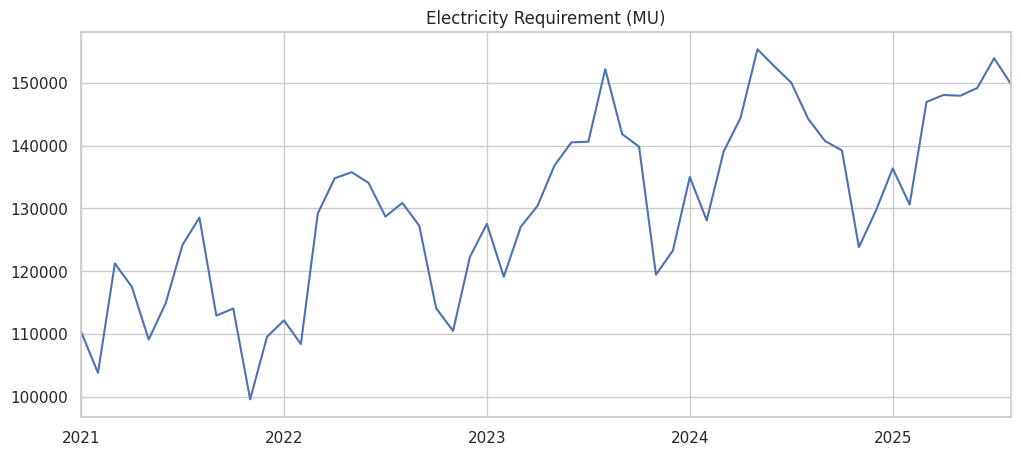

In [14]:
df['requirement_mu'].plot(title='Electricity Requirement (MU)')
plt.show()

plot temp

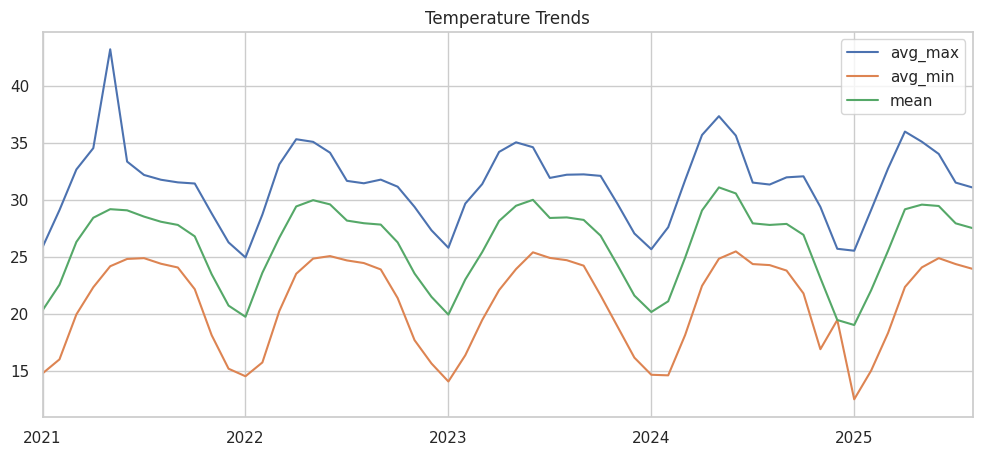

In [15]:
df[['avg_max','avg_min','mean']].plot(title='Temperature Trends')
plt.show()

exogenous plot

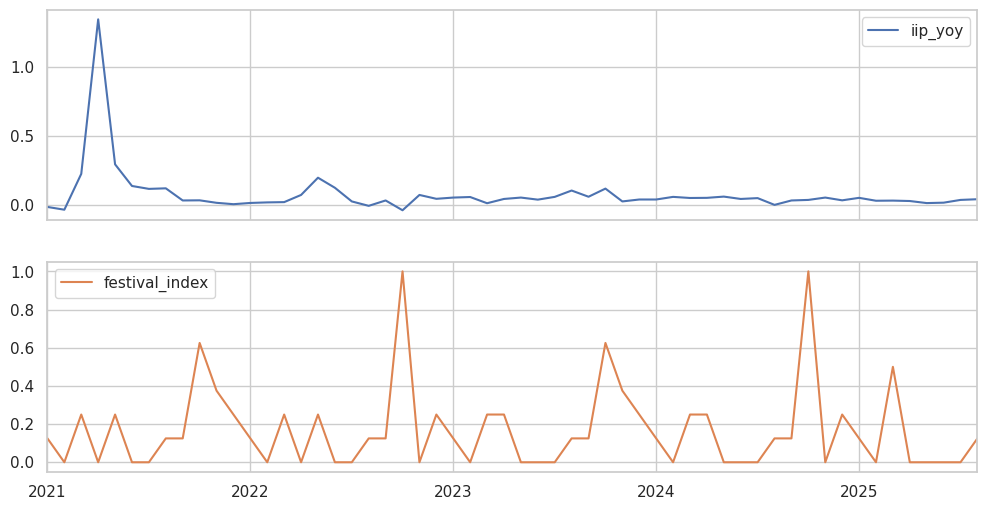

In [16]:
df[['iip_yoy','festival_index']].plot(subplots=True, figsize=(12,6))
plt.show()

decomposition

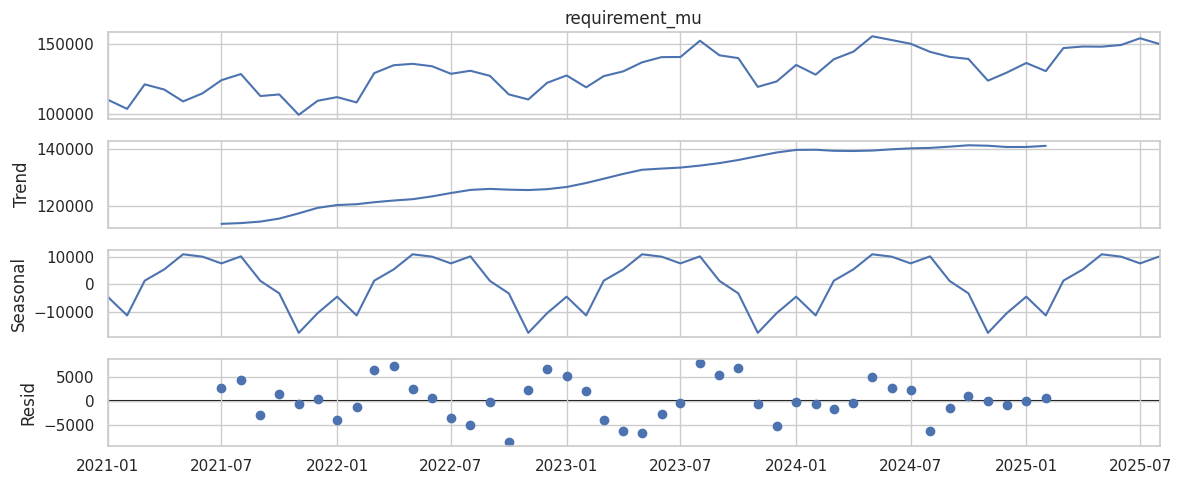

In [17]:
series = df['requirement_mu'].astype(float).to_timestamp()
res = seasonal_decompose(series, period=12, model='additive')
res.plot(); plt.show()

acf/pacf

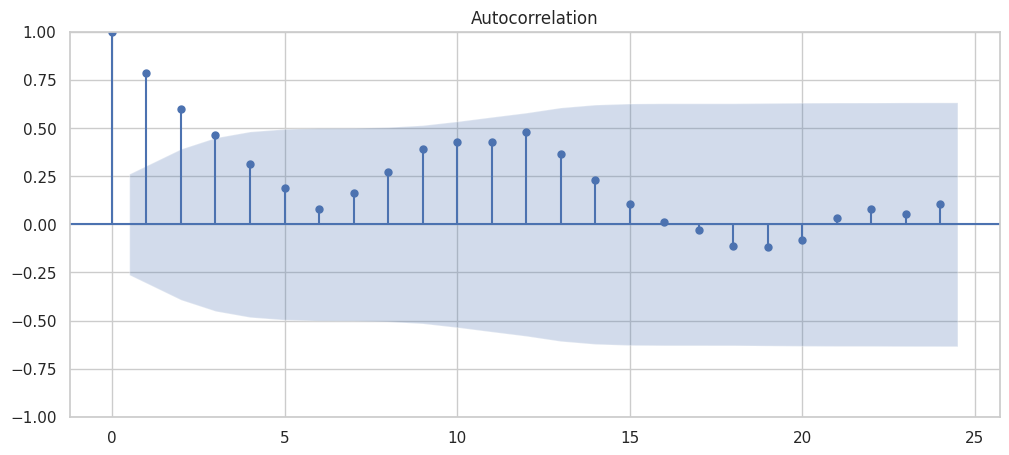

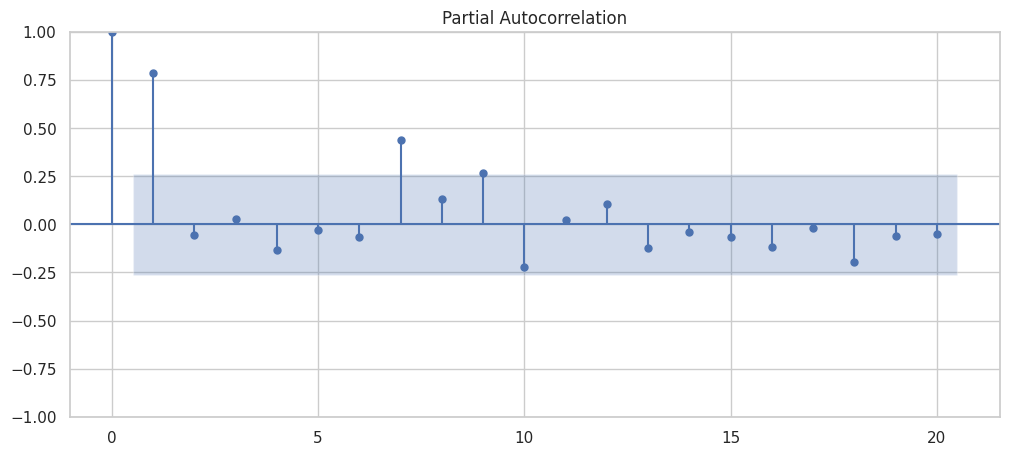

In [20]:
plot_acf(series.dropna(), lags=24)
plt.show()
plot_pacf(series.dropna(), lags=20)
plt.show()

#Train/test split

splitting

In [21]:
train = df.loc[:'2024-08']
test  = df.loc['2024-09':]
train.shape, test.shape

((44, 9), (12, 9))

exog scaling

In [22]:
exog_cols = ['avg_max','iip_yoy','festival_index']

scaler = StandardScaler()
train_exog = pd.DataFrame(scaler.fit_transform(train[exog_cols]), index=train.index, columns=exog_cols)
test_exog = pd.DataFrame(scaler.transform(test[exog_cols]), index=test.index, columns=exog_cols)

#Scaling exogenous variables

In [23]:
#z-score
exog_cols = ['avg_max','avg_min','iip_yoy','festival_index']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_exog = scaler.fit_transform(train[exog_cols])
test_exog = scaler.transform(test[exog_cols])

train_exog = pd.DataFrame(train_exog, index=train.index, columns=exog_cols)
test_exog = pd.DataFrame(test_exog, index=test.index, columns=exog_cols)

#MODEL-1 : ARIMA

In [24]:
y_train = train['requirement_mu'].astype(float)

p_vals = [0,1,2]
d_vals = [0,1]
q_vals = [0,1,2]

best_aic_arima = np.inf
best_order_arima = None
best_res_arima = None

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            order = (p,d,q)
            try:
                model = sm.tsa.statespace.SARIMAX(y_train, order=order, seasonal_order=(0,0,0,0))
                res = model.fit(disp=False)
                if res.aic < best_aic_arima:
                    best_aic_arima = res.aic
                    best_order_arima = order
                    best_res_arima = res
            except:
                pass

best_order_arima, best_aic_arima

((0, 1, 0), np.float64(905.9308058579586))

Forecast

In [25]:
pred = best_res_arima.get_forecast(steps=len(test))
arima_pred = pred.predicted_mean

metrics_arima = calc_metrics(test['requirement_mu'], arima_pred)
metrics_arima

{'MSE': 92058759.66666667, 'RMSE': 9594.725617059963, 'MAE': 7964.0}

Plotting

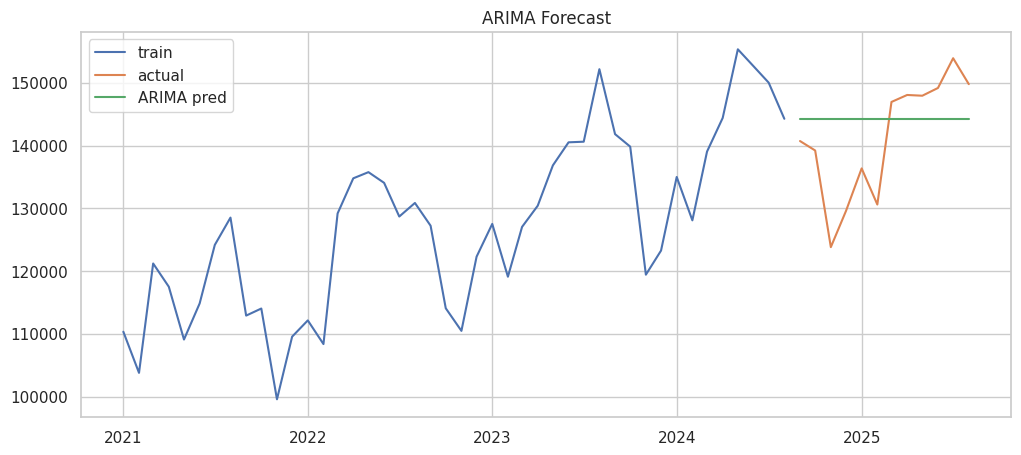

In [26]:
plt.plot(train.index.to_timestamp(), train['requirement_mu'], label='train')
plt.plot(test.index.to_timestamp(), test['requirement_mu'], label='actual')
plt.plot(test.index.to_timestamp(), arima_pred, label='ARIMA pred')
plt.legend(); plt.title('ARIMA Forecast'); plt.show()

#MODEL-2 : SARIMA

In [27]:
p_vals = [0,1,2]
d_vals = [0,1]
q_vals = [0,1,2]
P_vals = [0,1]
Q_vals = [0,1]
D = 1
m = 12

best_aic_sarima = np.inf
best_order_sarima = None
best_seasonal_sarima = None
best_res_sarima = None

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            for P in P_vals:
                for Q in Q_vals:
                    order = (p,d,q)
                    seasonal = (P,D,Q,m)
                    try:
                        model = sm.tsa.statespace.SARIMAX(y_train, order=order, seasonal_order=seasonal)
                        res = model.fit(disp=False)
                        if res.aic < best_aic_sarima:
                            best_aic_sarima = res.aic
                            best_order_sarima = order
                            best_seasonal_sarima = seasonal
                            best_res_sarima = res
                    except:
                        pass

best_order_sarima, best_seasonal_sarima, best_aic_sarima

((2, 1, 2), (0, 1, 0, 12), np.float64(646.4206505760075))

forecast

In [28]:
sarima_pred = best_res_sarima.get_forecast(steps=len(test)).predicted_mean
metrics_sarima = calc_metrics(test['requirement_mu'], sarima_pred)
metrics_sarima

{'MSE': 30001422.220143173,
 'RMSE': 5477.355403855329,
 'MAE': 4111.9406912846125}

plotting

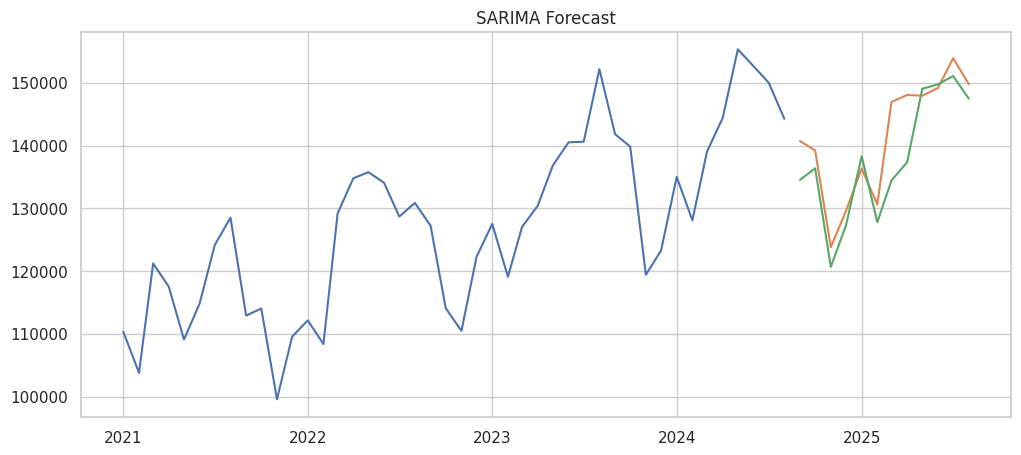

In [29]:
plt.plot(train.index.to_timestamp(), train['requirement_mu'])
plt.plot(test.index.to_timestamp(), test['requirement_mu'])
plt.plot(test.index.to_timestamp(), sarima_pred)
plt.title('SARIMA Forecast'); plt.show()

#MODEL-3 : SARIMAX
(with exogenous)

In [30]:
best_aic_sarimax = np.inf
best_order_sarimax = None
best_seasonal_sarimax = None
best_res_sarimax = None

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            for P in P_vals:
                for Q in Q_vals:
                    order = (p,d,q)
                    seasonal = (P,D,Q,m)
                    try:
                        model = sm.tsa.statespace.SARIMAX(
                            y_train,
                            order=order,
                            seasonal_order=seasonal,
                            exog=train_exog
                        )
                        res = model.fit(disp=False)
                        if res.aic < best_aic_sarimax:
                            best_aic_sarimax = res.aic
                            best_order_sarimax = order
                            best_seasonal_sarimax = seasonal
                            best_res_sarimax = res
                    except:
                        pass

best_order_sarimax, best_seasonal_sarimax, best_aic_sarimax

((2, 1, 2), (1, 1, 1, 12), np.float64(644.4887610251078))

forecast

In [31]:
pred = best_res_sarimax.get_forecast(steps=len(test), exog=test_exog)
sarimax_pred = pred.predicted_mean

metrics_sarimax = calc_metrics(test['requirement_mu'], sarimax_pred)
metrics_sarimax

{'MSE': 32961164.531398486,
 'RMSE': 5741.181457801041,
 'MAE': 5097.544400354921}

plotting

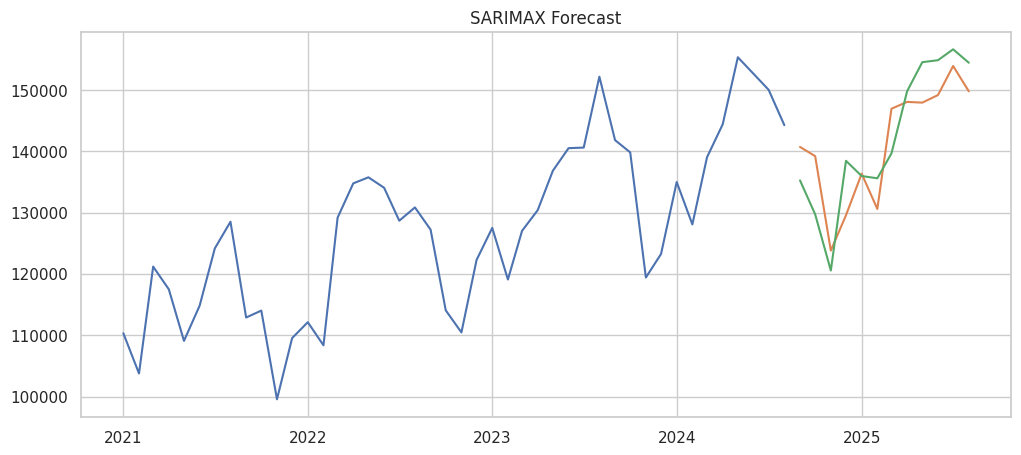

In [32]:
plt.plot(train.index.to_timestamp(), train['requirement_mu'])
plt.plot(test.index.to_timestamp(), test['requirement_mu'])
plt.plot(test.index.to_timestamp(), sarimax_pred)
plt.title('SARIMAX Forecast'); plt.show()

interpreting coefficients

In [33]:
best_res_sarimax.params.filter(like='x')

,0
avg_max,-552.296521
festival_index,-2898.258683


#COMPARISON of MODELS 1, 2, and 3

In [34]:
comparison = pd.DataFrame({
    'Model':['ARIMA','SARIMA','SARIMAX'],
    'AIC':[best_aic_arima, best_aic_sarima, best_aic_sarimax],
    'RMSE':[metrics_arima['RMSE'], metrics_sarima['RMSE'], metrics_sarimax['RMSE']],
    'MAE':[metrics_arima['MAE'], metrics_sarima['MAE'], metrics_sarimax['MAE']]
})

comparison

,Model,AIC,RMSE,MAE
0,ARIMA,905.930806,9594.725617,7964.000000
1,SARIMA,646.420651,5477.355404,4111.940691
2,SARIMAX,644.488761,5741.181458,5097.544400


In [36]:
best_res_sarimax.save(base_path + 'sarimax_final.pkl')
pd.DataFrame({
    'actual': test['requirement_mu'],
    'predicted': sarimax_pred
}).to_csv(base_path + 'sarimax_predictions.csv')

print("Saved model and predictions.")

Saved model and predictions.


The End.